# Radial profiles

In [ ]:
from postEoR.tools import create_spherical_profile
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(1, 1)
orig_rad = np.linspace(0, 1, 11)
redshifts = np.asarray([4, 4.07, 4.14, 4.21])
masses = np.asarray([1e9])#, 5e9, 1e10, 5e10])
labels = ["z=4", "z=4.07", "z=4.14", "z=4.21"]
colors = ["tab:cyan", "tab:pink", "tab:green", "tab:red", "tab:blue"]
#ax.set_title("$1 \\times 10^9$ M$_{\odot}$/h")
"""ax[0, 1].set_title("$5 \\times 10^9$ M$_{\odot}$/h")
ax[1, 0].set_title("$1 \\times 10^{10}$ M$_{\odot}$/h")
ax[1, 1].set_title("$5 \\times 10^{10}$ M$_{\odot}$/h")"""
ax.set_ylabel("$\\rho_{HI}(r)$, M$_{\odot}$/h / (Mpc/h)$^3$")
#ax[1, 0].set_ylabel("$\\rho_{HI}(r)$, M$_{\odot}$/h / (Mpc/h)$^3$")
ax.set_xlabel("r, Mpc/h")
#ax[1, 1].set_xlabel("r, Mpc/h")
plt.style.use('seaborn-v0_8-ticks')


for i in range(len(masses)):
    for ii in range(len(redshifts)):
        sph_prof = create_spherical_profile(masses[i], redshifts[ii], 0.1, 1)
        radial = sph_prof[10, 10, 10:] / 0.1 ** 3
        if i == 0:
            ax.plot(orig_rad, radial, label=str(labels[ii]), color=colors[ii])
        elif i == 1: 
            ax[0, 1].plot(orig_rad, radial, label=str(labels[ii]), color=colors[ii])
        elif i == 2:
            ax[1, 0].plot(orig_rad, radial, label=str(labels[ii]), color=colors[ii])
        elif i == 3:
            ax[1, 1].plot(orig_rad, radial, label=str(labels[ii]), color=colors[ii])

ax.set_yscale("log")
"""ax[0, 1].set_yscale("log")
ax[1, 0].set_yscale("log")
ax[1, 1].set_yscale("log")"""
"""ax[0, 0].set_xscale("log")
ax[0, 1].set_xscale("log")
ax[1, 0].set_xscale("log")
ax[1, 1].set_xscale("log")"""
ax.legend()


# PS and bias 

Using input bins
Using input bins
Using input bins
Using input bins
Using input bins
Using input bins
Using input bins
Using input bins
Using input bins
Using input bins
Using input bins
Using input bins


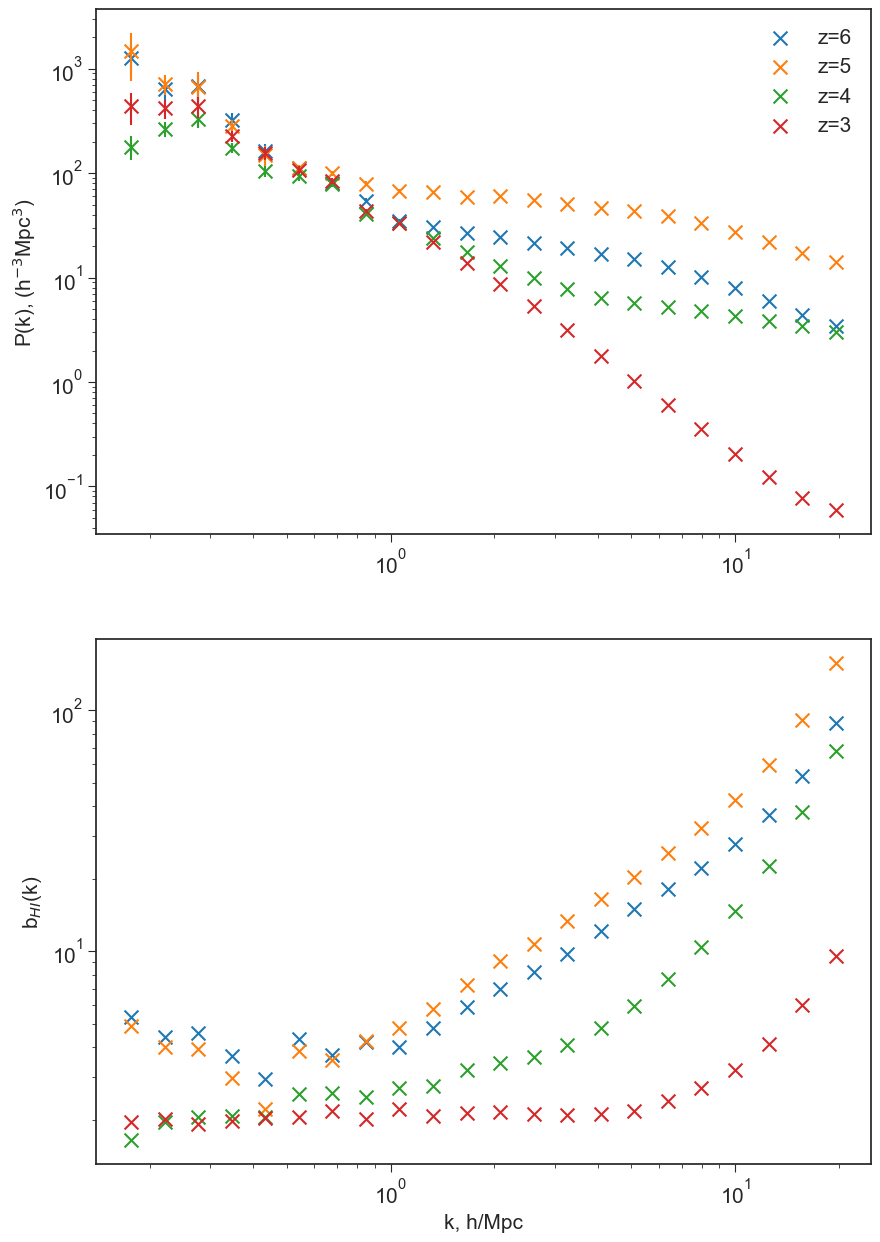

In [6]:
import postEoR.generation as gen
import matplotlib.pyplot as plt
import hickle as hkl
import numpy as np
from scipy.interpolate import make_interp_spline

plt.rcParams['figure.figsize'] = [10, 15]
fig, (ax1, ax2) = plt.subplots(2, 1)

redshifts=[6,5,4,3]
colors=["tab:blue", "tab:orange", "tab:green", "tab:red"]
labels=["z=6","z=5","z=4","z=3"]

for i in range(len(redshifts)):
    #box = gen.generate_box(redshifts[i], 250, 40)
    box = hkl.load("z"+str(format(redshifts[i], '.0f'))+"_box.hkl")
    ksx = np.fft.fftfreq(np.shape(box.BT_field)[0], (box.box_len / box.HII_dim)) * 2 * np.pi # max accessible wavenumber corresponds to 2 * pi
    ksy = np.fft.fftfreq(np.shape(box.BT_field)[1], (box.box_len / box.HII_dim)) * 2 * np.pi
    ksz = np.fft.fftfreq(np.shape(box.BT_field)[2], (box.box_len / box.HII_dim)) * 2 * np.pi
    kx, ky, kz = np.meshgrid(ksx, ksy, ksz) # converting to a 3d array
    k = (kx**2+ky**2+kz**2)**0.5 # spherical k-values
    k = k.reshape(np.size(k)) # converting to 1d array for use in binned_statistic
    kbins = np.geomspace(np.min(k[np.nonzero(k)]), np.max(k), 25)
    k, PS, err = box.get_PS("BT", norm=True, save_fig=False, kbins=kbins)
    ax1.scatter(k, PS, color=colors[i], label=labels[i], marker="x", s=100)
    ax1.errorbar(k, PS, err, color=colors[i], linestyle="none")

    kb, bias = box.get_bias()
    b = make_interp_spline(kb, bias, k=1)

    ax2.scatter(k, b(k), color=colors[i], label=labels[i], marker="x", s=100)
    #hkl.dump(box, "z" + str(redshifts[i]) + "_box.hkl")

plt.rcParams['figure.figsize'] = [10, 15]
ax1.set_yscale("log")
ax1.set_xscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("k, h/Mpc")
ax1.set_ylabel("P(k), (h$^{-3}$Mpc$^3$)")
ax2.set_ylabel("b$_{HI}$(k)")
ax1.legend()

# Coordinate transform RSDs

In [ ]:
import hickle as hkl
import numpy as np
import postEoR.tools as tools
from postEoR.tools import hlittle, Mpc_to_m, OMl, OMm

cone = hkl.load("cone_4_8_inhomo_recom.hkl")

vel = cone.Lightconer.lightcones["velocity_z"]
nchunks=100

new_BT_field = np.zeros(np.shape(cone.BT_field))

redshifts = np.flip(np.geomspace(cone.z_end, cone.z_start, nchunks+1))
chunk_indices = tools.z_to_index(cone.cell_size, redshifts)

for ii in range(np.size(chunk_indices) - 1):
    print(ii)
    start = round(chunk_indices[ii])
    end = round(chunk_indices[ii + 1])
    redshift = 0.5 * (redshifts[ii]+redshifts[ii+1])
    H_0 = hlittle * 100
    H = H_0 * 1000 / Mpc_to_m * (OMm * (1+redshift)**3+OMl)**0.5
    coord_transform = vel * hlittle / H
    index_transform = np.round(coord_transform / cone.cell_size, 0)

    for i in range(np.shape(cone.BT_field)[0]):
        for j in range(np.shape(cone.BT_field)[1]):
            for k in range(np.shape(cone.BT_field[:, :, start:end])[2]):
                try:
                    new_BT_field[i, j, start+k+int(index_transform[i, j, k])] += cone.BT_field[i, j, start+k]
                except IndexError:
                    pass

cone.BT_field = new_BT_field

# Mean power evolution

In [ ]:
import hickle as hkl
import numpy as np
import matplotlib.pyplot as plt
from postEoR.tools import get_distance
from postEoR.analysis import get_PS

no_k_bins = 15
redshift_bin = 0.3
asurv=100
tsurv=5000

plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn-v0_8-ticks')
plt.rcParams['figure.figsize'] = [8, 6]

def z_to_index(cone, bin_width):
    bin_edge=cone.z_end
    z_bins=list([])
    while bin_edge <= cone.z_start:
        z_bins.append(bin_edge)
        bin_edge += bin_width
    dist_bins = list([])
    for i in range(len(z_bins)):
        dist_bins.append(get_distance(z_bins[i]))
    indices = np.round((np.asarray(dist_bins) - dist_bins[0]) / cone.cell_size, 0)

    return indices, z_bins

cone = hkl.load("cone_4_8_inhomo_recom_new.hkl")

z_bins, indices = np.flip(z_to_index(cone, redshift_bin))
print(indices)
kbins = np.geomspace(0.06, 4, no_k_bins+1)

power_array = np.zeros((len(indices)-1, no_k_bins))

for i in range(len(indices)-1):
    BT = cone.BT_field
    BT = BT[:, :, int(indices[i+1]):int(indices[i])]
    print(np.shape(BT))

    _, power, _ = get_PS(BT, cone.box_len, cone.HII_dim, kbins, remove_nan=False)
    power_array[i, :] += power


cb1 = plt.pcolormesh(kbins, z_bins, power_array, cmap="jet", norm='log')
plt.xscale("log")
plt.ylabel("z")
plt.xlabel("k, h/Mpc")
cbar1 = plt.colorbar(cb1)
cbar1.set_label("P(k), K$^2$(Mpc/h)$^3$", rotation=270, labelpad = 15)
plt.tight_layout()